In [1]:
import kagglehub

# download dataset
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to downloaded dataset:", data_dir)

# Path to downloaded dataset: /Users/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1
# Path to downloaded dataset: /home/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1

/home/hongong/anaconda3/envs/aio2024-homework/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to downloaded dataset: /home/hongong/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

# Data preparation

In [23]:
class ImageDataset(Dataset):

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for objj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                # keep images that have single object
                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label = None
        bbox = None
        for obj in root.findall("object"):
            name = obj.find("name").text

            # take the first label
            if label is None:
                label = name

                # get bounding box coordinates
                xmin = int(obj.find("bndbox/xmin").text)
                ymin = int(obj.find("bndbox/ymin").text)
                xmax = int(obj.find("bndbox/xmax").text)
                ymax = int(obj.find("bndbox/ymax").text)

                # normalize bounding box coordinates to [0, 1]
                bbox = (
                    xmin / image_width,
                    ymin / image_height,
                    xmax / image_width,
                    ymax / image_height,
                )

        # convert label to numerical representation (0: cat, 1: dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __init__(self, annotations_dir, image_dir, transforms=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_files = self.filter_images_with_multiple_objects()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # load image
        image = Image.open(img_path).convert("RGB")

        # annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # parse annotation
        label, bbox = self.parse_annotation(annotation_path)

        if self.transforms:
            image = self.transforms(image)

        return image, label, bbox

In [24]:
# Data directory
annotations_dir = os.path.join(data_dir, "annotations")
image_dir = os.path.join(data_dir, "images")

# Get list of image files and create a dummy dataframe to split the data
image_files = [
    f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))
]
df = pd.DataFrame({"image_name": image_files})
print(df.shape)
df.head()

(3686, 1)


,image_name
0,Cats_Test442.png
1,Cats_Test630.png
2,Cats_Test351.png
3,Cats_Test1659.png
4,Cats_Test353.png


In [25]:
# split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
print(train_df.shape, val_df.shape)

(2948, 1) (738, 1)


In [26]:
# Transforms
trans = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transforms=trans)
val_dataset = ImageDataset(annotations_dir, image_dir, transforms=trans)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [
    f for f in train_dataset.image_files if f in train_df["image_name"].values
]
val_dataset.image_files = [
    f for f in val_dataset.image_files if f in val_df["image_name"].values
]

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(len(train_loader), len(val_loader))

93 24


In [27]:
# print sample data
sample_data = next(iter(train_loader))
images, labels, bboxes = sample_data
print(images.shape, labels.shape, bboxes.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 4])


# Modeling 2 heads

In [28]:
class TwoHeadedModel(nn.Module):

    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features

        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()

        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)

        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        return class_logits, bbox_coords

In [29]:
model = TwoHeadedModel()
model

TwoHeadedModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [30]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

In [31]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets, bboxes) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        scores, pred_bboxes = model(data)
        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox  # Combine losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss_bbox = 0
        total_samples = 0
        for data, targets, bboxes in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            bboxes = bboxes.to(device)

            scores, pred_bboxes = model(data)
            _, predictions = scores.max(1)
            correct += (predictions == targets).sum()
            total += targets.size(0)

            # Calculate bbox loss for monitoring (optional)
            total_loss_bbox += criterion_bbox(pred_bboxes, bboxes).item() * data.size(0)
            total_samples += data.size(0)

        avg_loss_bbox = total_loss_bbox / total_samples
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {float(correct) / float(total) * 100:.2f}%, "
            f"Avg. Bbox Loss: {avg_loss_bbox:.4f}"
        )

Epoch 1/10, Validation Accuracy: 77.78%, Avg. Bbox Loss: 0.0175
Epoch 2/10, Validation Accuracy: 88.62%, Avg. Bbox Loss: 0.0135
Epoch 3/10, Validation Accuracy: 90.65%, Avg. Bbox Loss: 0.0110
Epoch 4/10, Validation Accuracy: 94.99%, Avg. Bbox Loss: 0.0108
Epoch 5/10, Validation Accuracy: 95.39%, Avg. Bbox Loss: 0.0089
Epoch 6/10, Validation Accuracy: 89.97%, Avg. Bbox Loss: 0.0099
Epoch 7/10, Validation Accuracy: 93.22%, Avg. Bbox Loss: 0.0097
Epoch 8/10, Validation Accuracy: 92.28%, Avg. Bbox Loss: 0.0078
Epoch 9/10, Validation Accuracy: 95.53%, Avg. Bbox Loss: 0.0075
Epoch 10/10, Validation Accuracy: 86.18%, Avg. Bbox Loss: 0.0096


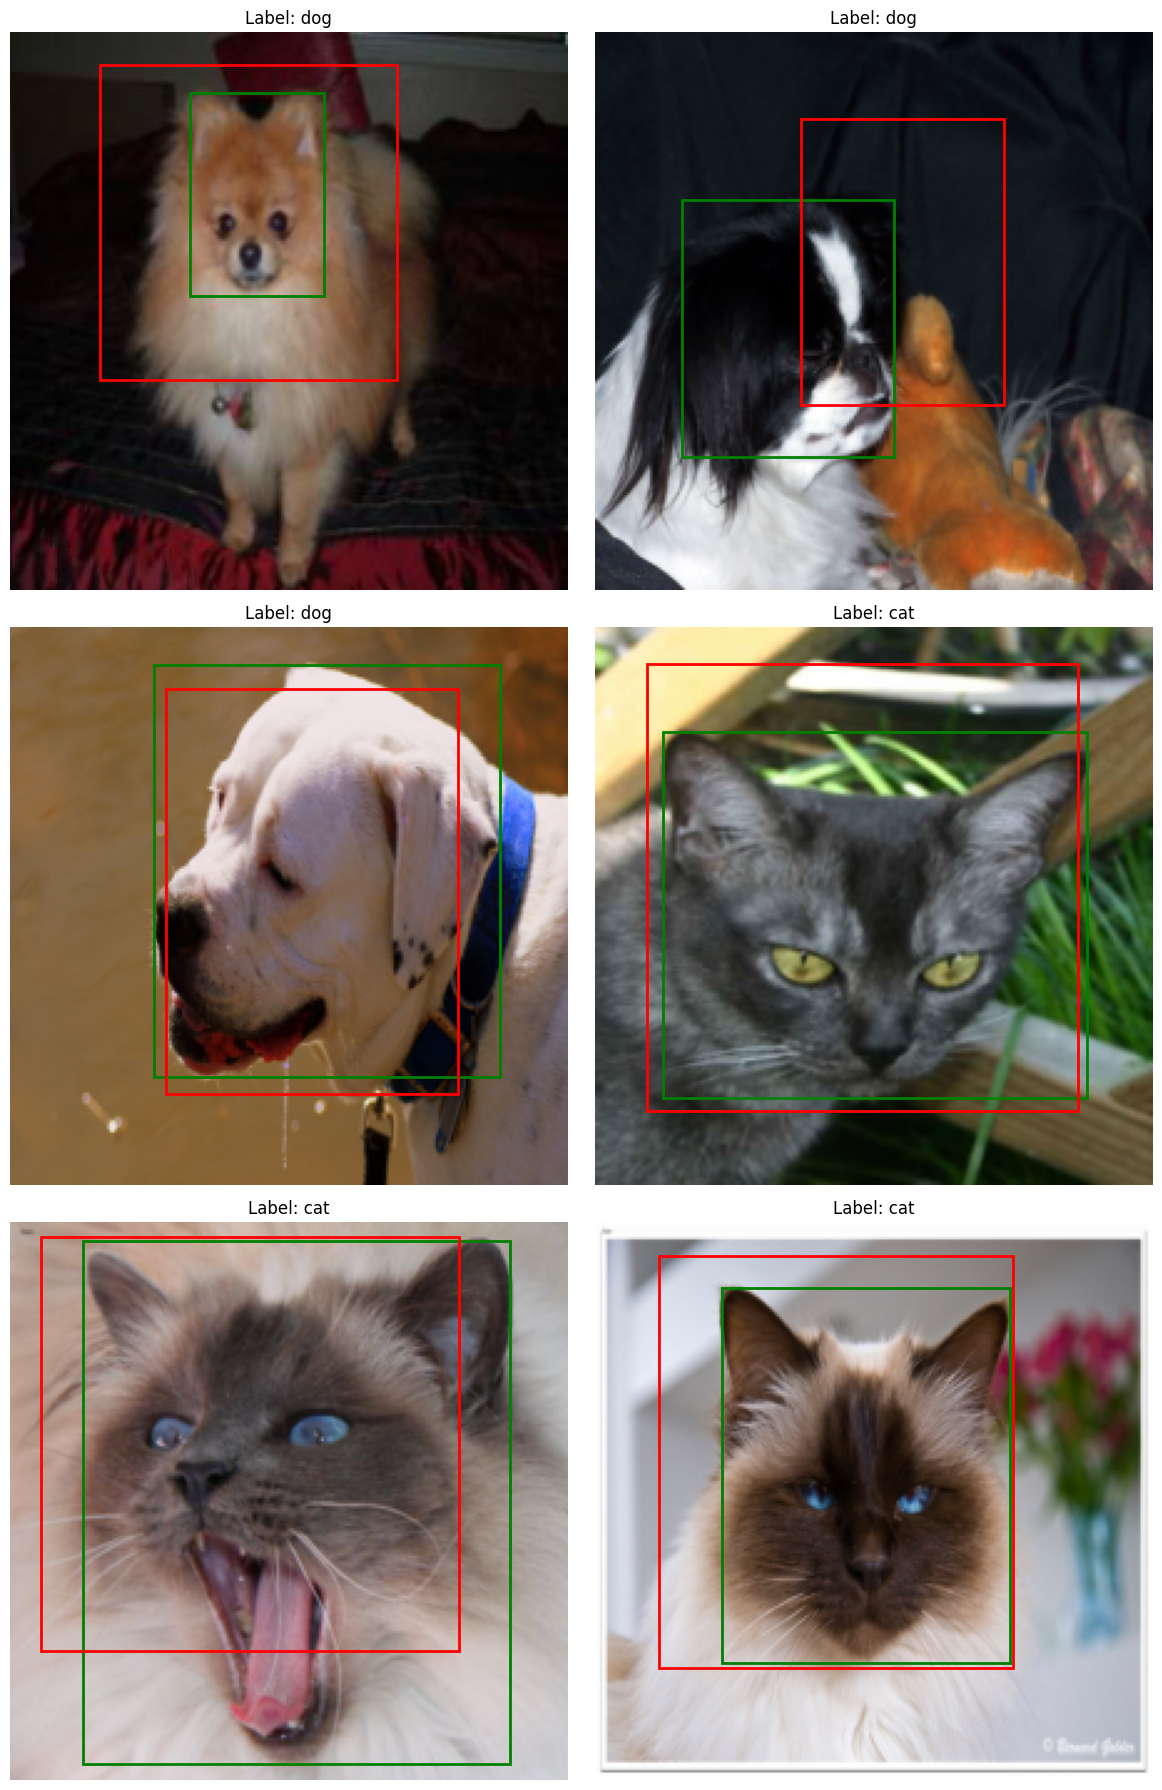

In [33]:
# plot images (3 rows, 2 columns) with labels and bounding boxes (predicted vs actual)


def plot_images_with_bboxes(
    images, labels, bboxes, pred_bboxes, class_names, num_images=6
):
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    axes = axes.flatten()

    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        ax = axes[i]
        ax.imshow(img)
        ax.set_title(f"Label: {class_names[labels[i]]}")

        # Actual bounding box
        bbox = bboxes[i].cpu().numpy()
        rect = plt.Rectangle(
            (bbox[0] * img.shape[1], bbox[1] * img.shape[0]),
            (bbox[2] - bbox[0]) * img.shape[1],
            (bbox[3] - bbox[1]) * img.shape[0],
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)

        # Predicted bounding box
        pred_bbox = pred_bboxes[i].cpu().numpy()
        rect = plt.Rectangle(
            (pred_bbox[0] * img.shape[1], pred_bbox[1] * img.shape[0]),
            (pred_bbox[2] - pred_bbox[0]) * img.shape[1],
            (pred_bbox[3] - pred_bbox[1]) * img.shape[0],
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Plot sample images with bounding boxes
plot_images_with_bboxes(images, labels, bboxes, pred_bboxes, class_names)